In [475]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import pprint 
import warnings 
import os 
import tensorflow as tf 
import random 
warnings.filterwarnings('ignore')
sns.set_style('darkgrid')

In [476]:
# set seed_value to make result reproducible
def reproduce():
    os.environ['PYTHONHASHSEED'] = str(42)
    random.seed(42)
    np.random.seed(42)
    tf.random.set_seed(42)

## Training Data 

In [477]:
# load training data
trainData = pd.read_csv('SalaryData_Test.csv')
trainData.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [478]:
# encoding of categorical data
# is necessary 
trainData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


In [479]:
# no null values present 
trainData.isnull().sum()

age              0
workclass        0
education        0
educationno      0
maritalstatus    0
occupation       0
relationship     0
race             0
sex              0
capitalgain      0
capitalloss      0
hoursperweek     0
native           0
Salary           0
dtype: int64

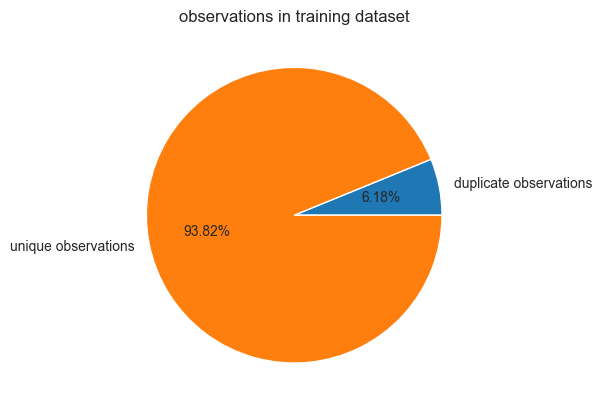

In [480]:
# 6.18% observations are duplicate rows 
plt.pie([trainData.duplicated().sum(),
             trainData.shape[0]-trainData.duplicated().sum()],labels=['duplicate observations',
                                                         'unique observations'],
         normalize=True,autopct='%.2f%%')
plt.title('observations in training dataset')
plt.show()

In [481]:
# drop duplicate rows 
trainData.drop_duplicates(inplace=True)
print(f'No. of duplicate observations present : {trainData.duplicated().sum()}')

No. of duplicate observations present : 0


In [482]:
# features with categorical data 
cols = [x for x in trainData.columns if trainData[x].dtype == 'object']
cols

['workclass',
 'education',
 'maritalstatus',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native',
 'Salary']

### feature data

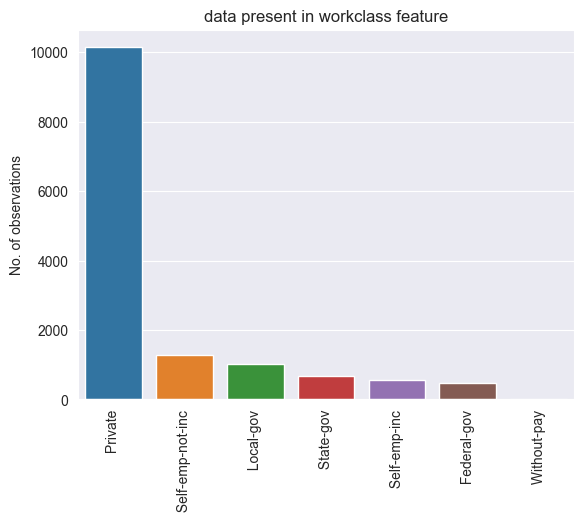

In [483]:
n = trainData['workclass'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in workclass feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

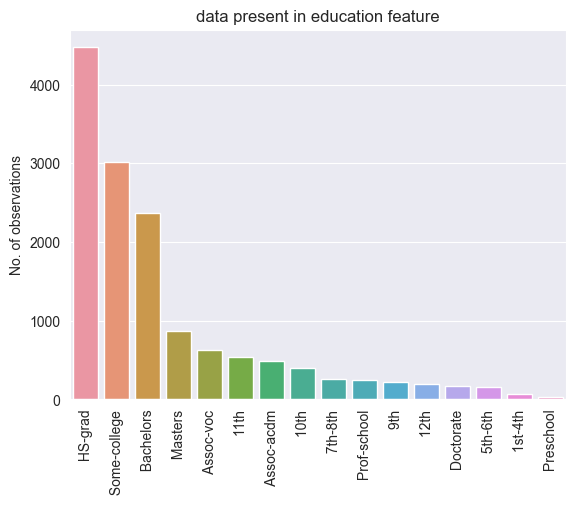

In [484]:
n = trainData['education'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in education feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

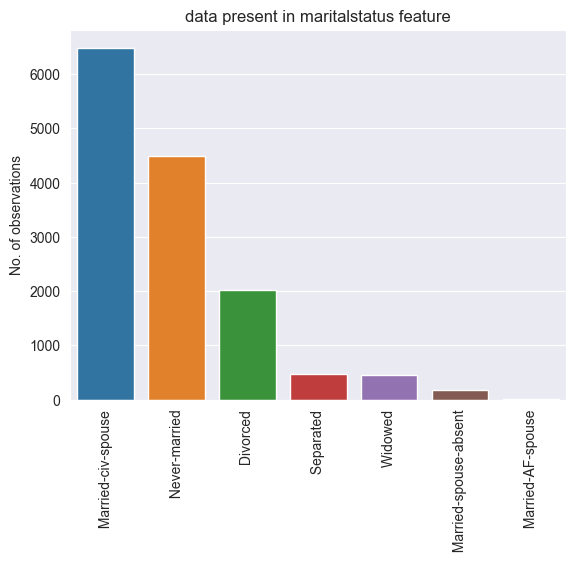

In [485]:
n = trainData['maritalstatus'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in maritalstatus feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

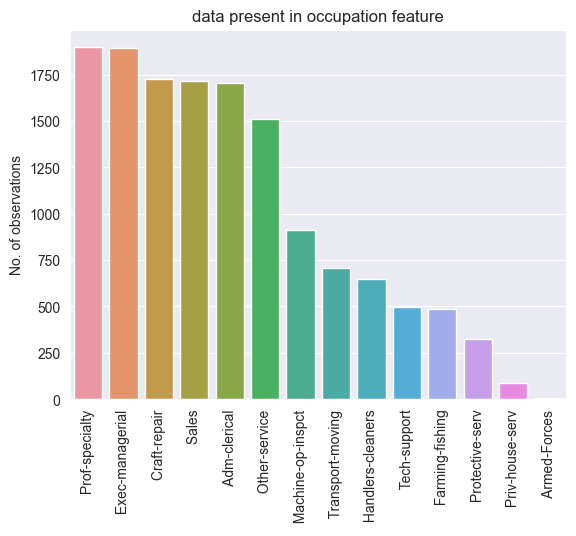

In [486]:
n = trainData['occupation'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in occupation feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

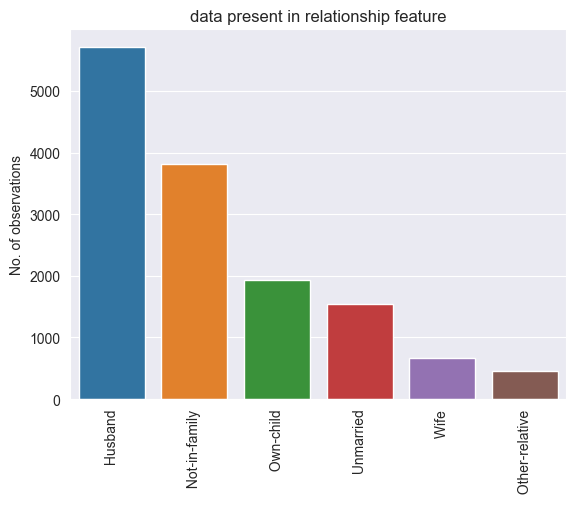

In [487]:
n = trainData['relationship'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in relationship feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

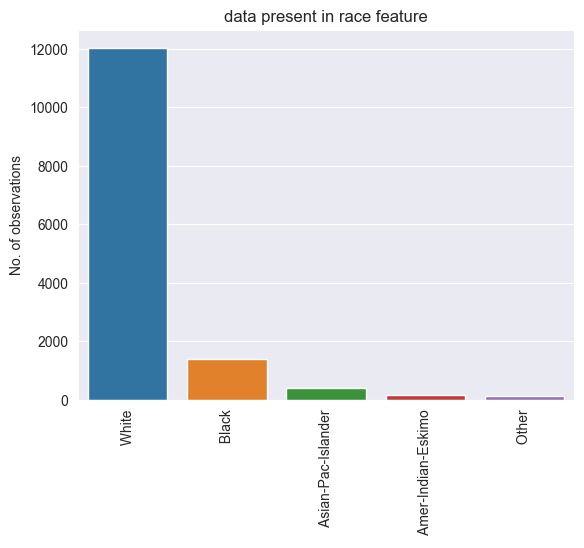

In [488]:
n = trainData['race'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in race feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

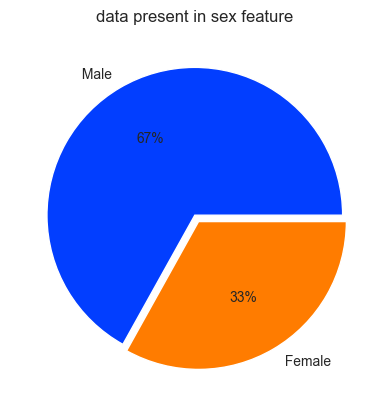

In [489]:
n = trainData[['sex']].value_counts()
explode = [0,0.05]
plt.pie(n.values,labels=[i[0] for i in n.index],explode=explode,
        colors=sns.color_palette('bright'),autopct='%.0f%%')
plt.title('data present in sex feature')
plt.show()

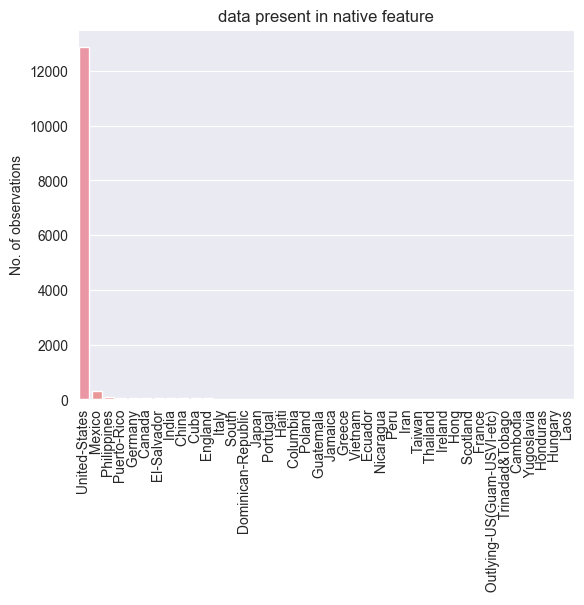

In [490]:
n = trainData['native'].value_counts()
sns.barplot(x=n.index,y=n.values)
plt.title('data present in native feature')
plt.ylabel('No. of observations')
plt.xticks(rotation=90)
plt.show()

### target data

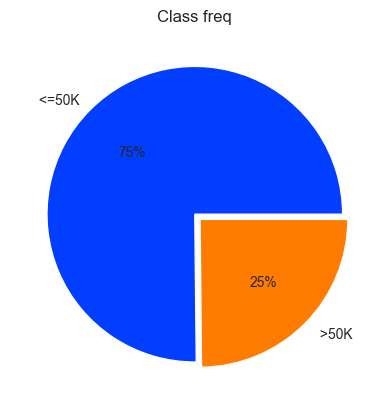

In [491]:
# target contains 2 unique classes
# there is imbalance in target data 
# don't rely on accuracy for model evaluation
n = trainData[['Salary']].value_counts()
explode = [0,0.05]
plt.pie(n.values,labels=[i[0] for i in n.index],explode=explode,
        colors=sns.color_palette('bright'),autopct='%.0f%%')

plt.title('Class freq')
plt.show()

### encoding categorical features of training data 

In [492]:
# encoding training data
encDict = {}
enc_trainData = trainData.copy(deep=True)
for col, dtype in tuple(zip(trainData.dtypes.index,trainData.dtypes.values)):
    if dtype == 'object':
        enc = LabelEncoder()
        enc_trainData[col] = enc.fit_transform(trainData[col])
        encData = dict(zip(np.arange(enc.classes_.size),enc.classes_))
        encDict[col] = encData
pprint.pprint(encDict)

{'Salary': {0: ' <=50K', 1: ' >50K'},
 'education': {0: ' 10th',
               1: ' 11th',
               2: ' 12th',
               3: ' 1st-4th',
               4: ' 5th-6th',
               5: ' 7th-8th',
               6: ' 9th',
               7: ' Assoc-acdm',
               8: ' Assoc-voc',
               9: ' Bachelors',
               10: ' Doctorate',
               11: ' HS-grad',
               12: ' Masters',
               13: ' Preschool',
               14: ' Prof-school',
               15: ' Some-college'},
 'maritalstatus': {0: ' Divorced',
                   1: ' Married-AF-spouse',
                   2: ' Married-civ-spouse',
                   3: ' Married-spouse-absent',
                   4: ' Never-married',
                   5: ' Separated',
                   6: ' Widowed'},
 'native': {0: ' Cambodia',
            1: ' Canada',
            2: ' China',
            3: ' Columbia',
            4: ' Cuba',
            5: ' Dominican-Republic',
            6: '

In [493]:
# encoded feature data 
X_train = enc_trainData.iloc[:,:-1]
X_train.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native
0,25,2,1,7,4,6,3,2,1,0,0,40,37
1,38,2,11,9,2,4,0,4,1,0,0,50,37
2,28,1,7,12,2,10,0,4,1,0,0,40,37
3,44,2,15,10,2,6,0,2,1,7688,0,40,37
4,34,2,0,6,4,7,1,4,1,0,0,30,37


In [494]:
# encoded target data 
# 'Salary': {0: ' <=50K', 1: ' >50K'}
Y_train = enc_trainData[['Salary']]
Y_train.head()

,Salary
0,0
1,0
2,1
3,1
4,0


## Testing Data 

In [495]:
# load testing data 
testData = pd.read_csv('SalaryData_Test.csv')
testData.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


In [496]:
# encoding of categorical data
# is necessary 
testData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15060 entries, 0 to 15059
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   age            15060 non-null  int64 
 1   workclass      15060 non-null  object
 2   education      15060 non-null  object
 3   educationno    15060 non-null  int64 
 4   maritalstatus  15060 non-null  object
 5   occupation     15060 non-null  object
 6   relationship   15060 non-null  object
 7   race           15060 non-null  object
 8   sex            15060 non-null  object
 9   capitalgain    15060 non-null  int64 
 10  capitalloss    15060 non-null  int64 
 11  hoursperweek   15060 non-null  int64 
 12  native         15060 non-null  object
 13  Salary         15060 non-null  object
dtypes: int64(5), object(9)
memory usage: 1.6+ MB


### encoding categorical features of testing data

In [497]:
enc_testData = testData.copy(deep=True)
for col in cols:
    rev_encDict = dict(zip(encDict[col].values(),encDict[col].keys()))
    enc_testData[[col]] = enc_testData[[col]].replace(rev_encDict,regex=True)

In [498]:
enc_testData

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,Salary
0,25,2,1,7,4,6,3,2,1,0,0,40,37,0
1,38,2,11,9,2,4,0,4,1,0,0,50,37,0
2,28,1,7,12,2,10,0,4,1,0,0,40,37,1
3,44,2,15,10,2,6,0,2,1,7688,0,40,37,1
4,34,2,0,6,4,7,1,4,1,0,0,30,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15055,33,2,9,13,4,9,3,4,1,0,0,40,37,0
15056,39,2,9,13,0,9,1,4,0,0,0,36,37,0
15057,38,2,9,13,2,9,0,4,1,0,0,50,37,0
15058,44,2,9,13,0,0,3,1,1,5455,0,40,37,0


In [499]:
# testing data 
X_test = enc_trainData.iloc[:,:-1]
Y_test = enc_trainData[['Salary']]

## Gaussian Naive Bayes Classification Model

In [500]:
# hyperparameter 'var_smoothing' tuning 
reproduce()
base_GB = GaussianNB()
param_grid = {'var_smoothing':np.logspace(0,-9,num=100)}
grid_GB = GridSearchCV(estimator=base_GB,
                       param_grid=param_grid,
                       cv=10,verbose=10,scoring='accuracy')
grid_GB.fit(X_train,Y_train.values.ravel())

Fitting 10 folds for each of 100 candidates, totalling 1000 fits
[CV 1/10; 1/100] START var_smoothing=1.0........................................
[CV 1/10; 1/100] END .........var_smoothing=1.0;, score=0.764 total time=   0.0s
[CV 2/10; 1/100] START var_smoothing=1.0........................................
[CV 2/10; 1/100] END .........var_smoothing=1.0;, score=0.757 total time=   0.0s
[CV 3/10; 1/100] START var_smoothing=1.0........................................
[CV 3/10; 1/100] END .........var_smoothing=1.0;, score=0.757 total time=   0.0s
[CV 4/10; 1/100] START var_smoothing=1.0........................................
[CV 4/10; 1/100] END .........var_smoothing=1.0;, score=0.760 total time=   0.0s
[CV 5/10; 1/100] START var_smoothing=1.0........................................
[CV 5/10; 1/100] END .........var_smoothing=1.0;, score=0.762 total time=   0.0s
[CV 6/10; 1/100] START var_smoothing=1.0........................................
[CV 6/10; 1/100] END .........var_smoothing=

[CV 10/10; 5/100] END var_smoothing=0.43287612810830584;, score=0.774 total time=   0.0s
[CV 1/10; 6/100] START var_smoothing=0.3511191734215131.........................
[CV 1/10; 6/100] END var_smoothing=0.3511191734215131;, score=0.779 total time=   0.0s
[CV 2/10; 6/100] START var_smoothing=0.3511191734215131.........................
[CV 2/10; 6/100] END var_smoothing=0.3511191734215131;, score=0.774 total time=   0.0s
[CV 3/10; 6/100] START var_smoothing=0.3511191734215131.........................
[CV 3/10; 6/100] END var_smoothing=0.3511191734215131;, score=0.771 total time=   0.0s
[CV 4/10; 6/100] START var_smoothing=0.3511191734215131.........................
[CV 4/10; 6/100] END var_smoothing=0.3511191734215131;, score=0.772 total time=   0.0s
[CV 5/10; 6/100] START var_smoothing=0.3511191734215131.........................
[CV 5/10; 6/100] END var_smoothing=0.3511191734215131;, score=0.775 total time=   0.0s
[CV 6/10; 6/100] START var_smoothing=0.3511191734215131................

[CV 2/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.793 total time=   0.0s
[CV 3/10; 11/100] START var_smoothing=0.12328467394420659.......................
[CV 3/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.790 total time=   0.0s
[CV 4/10; 11/100] START var_smoothing=0.12328467394420659.......................
[CV 4/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.792 total time=   0.0s
[CV 5/10; 11/100] START var_smoothing=0.12328467394420659.......................
[CV 5/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.796 total time=   0.0s
[CV 6/10; 11/100] START var_smoothing=0.12328467394420659.......................
[CV 6/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.788 total time=   0.0s
[CV 7/10; 11/100] START var_smoothing=0.12328467394420659.......................
[CV 7/10; 11/100] END var_smoothing=0.12328467394420659;, score=0.796 total time=   0.0s
[CV 8/10; 11/100] START var_smoothing=0.12328467394420659....

[CV 3/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.791 total time=   0.0s
[CV 4/10; 16/100] START var_smoothing=0.04328761281083057.......................
[CV 4/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.786 total time=   0.0s
[CV 5/10; 16/100] START var_smoothing=0.04328761281083057.......................
[CV 5/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.795 total time=   0.0s
[CV 6/10; 16/100] START var_smoothing=0.04328761281083057.......................
[CV 6/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.791 total time=   0.0s
[CV 7/10; 16/100] START var_smoothing=0.04328761281083057.......................
[CV 7/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.798 total time=   0.0s
[CV 8/10; 16/100] START var_smoothing=0.04328761281083057.......................
[CV 8/10; 16/100] END var_smoothing=0.04328761281083057;, score=0.793 total time=   0.0s
[CV 9/10; 16/100] START var_smoothing=0.04328761281083057....

[CV 4/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.784 total time=   0.0s
[CV 5/10; 21/100] START var_smoothing=0.01519911082952933.......................
[CV 5/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.794 total time=   0.0s
[CV 6/10; 21/100] START var_smoothing=0.01519911082952933.......................
[CV 6/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.783 total time=   0.0s
[CV 7/10; 21/100] START var_smoothing=0.01519911082952933.......................
[CV 7/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.795 total time=   0.0s
[CV 8/10; 21/100] START var_smoothing=0.01519911082952933.......................
[CV 8/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.785 total time=   0.0s
[CV 9/10; 21/100] START var_smoothing=0.01519911082952933.......................
[CV 9/10; 21/100] END var_smoothing=0.01519911082952933;, score=0.794 total time=   0.0s
[CV 10/10; 21/100] START var_smoothing=0.01519911082952933...

[CV 4/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.780 total time=   0.0s
[CV 5/10; 26/100] START var_smoothing=0.005336699231206307......................
[CV 5/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.792 total time=   0.0s
[CV 6/10; 26/100] START var_smoothing=0.005336699231206307......................
[CV 6/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.780 total time=   0.0s
[CV 7/10; 26/100] START var_smoothing=0.005336699231206307......................
[CV 7/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.791 total time=   0.0s
[CV 8/10; 26/100] START var_smoothing=0.005336699231206307......................
[CV 8/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.779 total time=   0.0s
[CV 9/10; 26/100] START var_smoothing=0.005336699231206307......................
[CV 9/10; 26/100] END var_smoothing=0.005336699231206307;, score=0.787 total time=   0.0s
[CV 10/10; 26/100] START var_smoothing=0.00533669923120

[CV 5/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.808 total time=   0.0s
[CV 6/10; 31/100] START var_smoothing=0.001873817422860383......................
[CV 6/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.783 total time=   0.0s
[CV 7/10; 31/100] START var_smoothing=0.001873817422860383......................
[CV 7/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.810 total time=   0.0s
[CV 8/10; 31/100] START var_smoothing=0.001873817422860383......................
[CV 8/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.791 total time=   0.0s
[CV 9/10; 31/100] START var_smoothing=0.001873817422860383......................
[CV 9/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.794 total time=   0.0s
[CV 10/10; 31/100] START var_smoothing=0.001873817422860383.....................
[CV 10/10; 31/100] END var_smoothing=0.001873817422860383;, score=0.804 total time=   0.0s
[CV 1/10; 32/100] START var_smoothing=0.00151991108295

[CV 6/10; 36/100] END var_smoothing=0.0006579332246575676;, score=0.776 total time=   0.0s
[CV 7/10; 36/100] START var_smoothing=0.0006579332246575676.....................
[CV 7/10; 36/100] END var_smoothing=0.0006579332246575676;, score=0.805 total time=   0.0s
[CV 8/10; 36/100] START var_smoothing=0.0006579332246575676.....................
[CV 8/10; 36/100] END var_smoothing=0.0006579332246575676;, score=0.783 total time=   0.0s
[CV 9/10; 36/100] START var_smoothing=0.0006579332246575676.....................
[CV 9/10; 36/100] END var_smoothing=0.0006579332246575676;, score=0.788 total time=   0.0s
[CV 10/10; 36/100] START var_smoothing=0.0006579332246575676....................
[CV 10/10; 36/100] END var_smoothing=0.0006579332246575676;, score=0.795 total time=   0.0s
[CV 1/10; 37/100] START var_smoothing=0.0005336699231206307.....................
[CV 1/10; 37/100] END var_smoothing=0.0005336699231206307;, score=0.792 total time=   0.0s
[CV 2/10; 37/100] START var_smoothing=0.00053366

[CV 7/10; 41/100] END var_smoothing=0.0002310129700083158;, score=0.805 total time=   0.0s
[CV 8/10; 41/100] START var_smoothing=0.0002310129700083158.....................
[CV 8/10; 41/100] END var_smoothing=0.0002310129700083158;, score=0.780 total time=   0.0s
[CV 9/10; 41/100] START var_smoothing=0.0002310129700083158.....................
[CV 9/10; 41/100] END var_smoothing=0.0002310129700083158;, score=0.788 total time=   0.0s
[CV 10/10; 41/100] START var_smoothing=0.0002310129700083158....................
[CV 10/10; 41/100] END var_smoothing=0.0002310129700083158;, score=0.795 total time=   0.0s
[CV 1/10; 42/100] START var_smoothing=0.0001873817422860383.....................
[CV 1/10; 42/100] END var_smoothing=0.0001873817422860383;, score=0.791 total time=   0.0s
[CV 2/10; 42/100] START var_smoothing=0.0001873817422860383.....................
[CV 2/10; 42/100] END var_smoothing=0.0001873817422860383;, score=0.787 total time=   0.0s
[CV 3/10; 42/100] START var_smoothing=0.00018738

[CV 8/10; 46/100] END var_smoothing=8.111308307896872e-05;, score=0.780 total time=   0.0s
[CV 9/10; 46/100] START var_smoothing=8.111308307896872e-05.....................
[CV 9/10; 46/100] END var_smoothing=8.111308307896872e-05;, score=0.788 total time=   0.0s
[CV 10/10; 46/100] START var_smoothing=8.111308307896872e-05....................
[CV 10/10; 46/100] END var_smoothing=8.111308307896872e-05;, score=0.795 total time=   0.0s
[CV 1/10; 47/100] START var_smoothing=6.579332246575683e-05.....................
[CV 1/10; 47/100] END var_smoothing=6.579332246575683e-05;, score=0.791 total time=   0.0s
[CV 2/10; 47/100] START var_smoothing=6.579332246575683e-05.....................
[CV 2/10; 47/100] END var_smoothing=6.579332246575683e-05;, score=0.787 total time=   0.0s
[CV 3/10; 47/100] START var_smoothing=6.579332246575683e-05.....................
[CV 3/10; 47/100] END var_smoothing=6.579332246575683e-05;, score=0.786 total time=   0.0s
[CV 4/10; 47/100] START var_smoothing=6.57933224

[CV 8/10; 51/100] END var_smoothing=2.848035868435799e-05;, score=0.780 total time=   0.0s
[CV 9/10; 51/100] START var_smoothing=2.848035868435799e-05.....................
[CV 9/10; 51/100] END var_smoothing=2.848035868435799e-05;, score=0.788 total time=   0.0s
[CV 10/10; 51/100] START var_smoothing=2.848035868435799e-05....................
[CV 10/10; 51/100] END var_smoothing=2.848035868435799e-05;, score=0.795 total time=   0.0s
[CV 1/10; 52/100] START var_smoothing=2.310129700083158e-05.....................
[CV 1/10; 52/100] END var_smoothing=2.310129700083158e-05;, score=0.791 total time=   0.0s
[CV 2/10; 52/100] START var_smoothing=2.310129700083158e-05.....................
[CV 2/10; 52/100] END var_smoothing=2.310129700083158e-05;, score=0.787 total time=   0.0s
[CV 3/10; 52/100] START var_smoothing=2.310129700083158e-05.....................
[CV 3/10; 52/100] END var_smoothing=2.310129700083158e-05;, score=0.786 total time=   0.0s
[CV 4/10; 52/100] START var_smoothing=2.31012970

[CV 9/10; 56/100] END ......var_smoothing=1e-05;, score=0.788 total time=   0.0s
[CV 10/10; 56/100] START var_smoothing=1e-05....................................
[CV 10/10; 56/100] END .....var_smoothing=1e-05;, score=0.795 total time=   0.0s
[CV 1/10; 57/100] START var_smoothing=8.111308307896873e-06.....................
[CV 1/10; 57/100] END var_smoothing=8.111308307896873e-06;, score=0.791 total time=   0.0s
[CV 2/10; 57/100] START var_smoothing=8.111308307896873e-06.....................
[CV 2/10; 57/100] END var_smoothing=8.111308307896873e-06;, score=0.786 total time=   0.0s
[CV 3/10; 57/100] START var_smoothing=8.111308307896873e-06.....................
[CV 3/10; 57/100] END var_smoothing=8.111308307896873e-06;, score=0.786 total time=   0.0s
[CV 4/10; 57/100] START var_smoothing=8.111308307896873e-06.....................
[CV 4/10; 57/100] END var_smoothing=8.111308307896873e-06;, score=0.788 total time=   0.0s
[CV 5/10; 57/100] START var_smoothing=8.111308307896873e-06..........

[CV 1/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.791 total time=   0.0s
[CV 2/10; 62/100] START var_smoothing=2.848035868435799e-06.....................
[CV 2/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.786 total time=   0.0s
[CV 3/10; 62/100] START var_smoothing=2.848035868435799e-06.....................
[CV 3/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.786 total time=   0.0s
[CV 4/10; 62/100] START var_smoothing=2.848035868435799e-06.....................
[CV 4/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.788 total time=   0.0s
[CV 5/10; 62/100] START var_smoothing=2.848035868435799e-06.....................
[CV 5/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.794 total time=   0.0s
[CV 6/10; 62/100] START var_smoothing=2.848035868435799e-06.....................
[CV 6/10; 62/100] END var_smoothing=2.848035868435799e-06;, score=0.773 total time=   0.0s
[CV 7/10; 62/100] START var_smoothing=2.848035868

[CV 1/10; 67/100] END ......var_smoothing=1e-06;, score=0.791 total time=   0.0s
[CV 2/10; 67/100] START var_smoothing=1e-06.....................................
[CV 2/10; 67/100] END ......var_smoothing=1e-06;, score=0.786 total time=   0.0s
[CV 3/10; 67/100] START var_smoothing=1e-06.....................................
[CV 3/10; 67/100] END ......var_smoothing=1e-06;, score=0.786 total time=   0.0s
[CV 4/10; 67/100] START var_smoothing=1e-06.....................................
[CV 4/10; 67/100] END ......var_smoothing=1e-06;, score=0.788 total time=   0.0s
[CV 5/10; 67/100] START var_smoothing=1e-06.....................................
[CV 5/10; 67/100] END ......var_smoothing=1e-06;, score=0.793 total time=   0.0s
[CV 6/10; 67/100] START var_smoothing=1e-06.....................................
[CV 6/10; 67/100] END ......var_smoothing=1e-06;, score=0.774 total time=   0.0s
[CV 7/10; 67/100] START var_smoothing=1e-06.....................................
[CV 7/10; 67/100] END ......

[CV 3/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.786 total time=   0.0s
[CV 4/10; 72/100] START var_smoothing=3.5111917342151277e-07....................
[CV 4/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.787 total time=   0.0s
[CV 5/10; 72/100] START var_smoothing=3.5111917342151277e-07....................
[CV 5/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.793 total time=   0.0s
[CV 6/10; 72/100] START var_smoothing=3.5111917342151277e-07....................
[CV 6/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.774 total time=   0.0s
[CV 7/10; 72/100] START var_smoothing=3.5111917342151277e-07....................
[CV 7/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.801 total time=   0.0s
[CV 8/10; 72/100] START var_smoothing=3.5111917342151277e-07....................
[CV 8/10; 72/100] END var_smoothing=3.5111917342151277e-07;, score=0.780 total time=   0.0s
[CV 9/10; 72/100] START var_smoothing=3.511

[CV 4/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.788 total time=   0.0s
[CV 5/10; 77/100] START var_smoothing=1.232846739442066e-07.....................
[CV 5/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.793 total time=   0.0s
[CV 6/10; 77/100] START var_smoothing=1.232846739442066e-07.....................
[CV 6/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.774 total time=   0.0s
[CV 7/10; 77/100] START var_smoothing=1.232846739442066e-07.....................
[CV 7/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.803 total time=   0.0s
[CV 8/10; 77/100] START var_smoothing=1.232846739442066e-07.....................
[CV 8/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.778 total time=   0.0s
[CV 9/10; 77/100] START var_smoothing=1.232846739442066e-07.....................
[CV 9/10; 77/100] END var_smoothing=1.232846739442066e-07;, score=0.787 total time=   0.0s
[CV 10/10; 77/100] START var_smoothing=1.23284673

[CV 4/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.788 total time=   0.0s
[CV 5/10; 82/100] START var_smoothing=4.3287612810830526e-08....................
[CV 5/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.793 total time=   0.0s
[CV 6/10; 82/100] START var_smoothing=4.3287612810830526e-08....................
[CV 6/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.775 total time=   0.0s
[CV 7/10; 82/100] START var_smoothing=4.3287612810830526e-08....................
[CV 7/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.805 total time=   0.0s
[CV 8/10; 82/100] START var_smoothing=4.3287612810830526e-08....................
[CV 8/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.781 total time=   0.0s
[CV 9/10; 82/100] START var_smoothing=4.3287612810830526e-08....................
[CV 9/10; 82/100] END var_smoothing=4.3287612810830526e-08;, score=0.788 total time=   0.0s
[CV 10/10; 82/100] START var_smoothing=4.32

[CV 6/10; 87/100] END var_smoothing=1.519911082952933e-08;, score=0.776 total time=   0.0s
[CV 7/10; 87/100] START var_smoothing=1.519911082952933e-08.....................
[CV 7/10; 87/100] END var_smoothing=1.519911082952933e-08;, score=0.805 total time=   0.0s
[CV 8/10; 87/100] START var_smoothing=1.519911082952933e-08.....................
[CV 8/10; 87/100] END var_smoothing=1.519911082952933e-08;, score=0.781 total time=   0.0s
[CV 9/10; 87/100] START var_smoothing=1.519911082952933e-08.....................
[CV 9/10; 87/100] END var_smoothing=1.519911082952933e-08;, score=0.789 total time=   0.0s
[CV 10/10; 87/100] START var_smoothing=1.519911082952933e-08....................
[CV 10/10; 87/100] END var_smoothing=1.519911082952933e-08;, score=0.795 total time=   0.0s
[CV 1/10; 88/100] START var_smoothing=1.232846739442066e-08.....................
[CV 1/10; 88/100] END var_smoothing=1.232846739442066e-08;, score=0.793 total time=   0.0s
[CV 2/10; 88/100] START var_smoothing=1.23284673

[CV 7/10; 92/100] END var_smoothing=5.336699231206302e-09;, score=0.805 total time=   0.0s
[CV 8/10; 92/100] START var_smoothing=5.336699231206302e-09.....................
[CV 8/10; 92/100] END var_smoothing=5.336699231206302e-09;, score=0.781 total time=   0.0s
[CV 9/10; 92/100] START var_smoothing=5.336699231206302e-09.....................
[CV 9/10; 92/100] END var_smoothing=5.336699231206302e-09;, score=0.792 total time=   0.0s
[CV 10/10; 92/100] START var_smoothing=5.336699231206302e-09....................
[CV 10/10; 92/100] END var_smoothing=5.336699231206302e-09;, score=0.795 total time=   0.0s
[CV 1/10; 93/100] START var_smoothing=4.328761281083061e-09.....................
[CV 1/10; 93/100] END var_smoothing=4.328761281083061e-09;, score=0.792 total time=   0.0s
[CV 2/10; 93/100] START var_smoothing=4.328761281083061e-09.....................
[CV 2/10; 93/100] END var_smoothing=4.328761281083061e-09;, score=0.793 total time=   0.0s
[CV 3/10; 93/100] START var_smoothing=4.32876128

[CV 9/10; 97/100] END var_smoothing=1.873817422860387e-09;, score=0.793 total time=   0.0s
[CV 10/10; 97/100] START var_smoothing=1.873817422860387e-09....................
[CV 10/10; 97/100] END var_smoothing=1.873817422860387e-09;, score=0.795 total time=   0.0s
[CV 1/10; 98/100] START var_smoothing=1.519911082952933e-09.....................
[CV 1/10; 98/100] END var_smoothing=1.519911082952933e-09;, score=0.795 total time=   0.0s
[CV 2/10; 98/100] START var_smoothing=1.519911082952933e-09.....................
[CV 2/10; 98/100] END var_smoothing=1.519911082952933e-09;, score=0.794 total time=   0.0s
[CV 3/10; 98/100] START var_smoothing=1.519911082952933e-09.....................
[CV 3/10; 98/100] END var_smoothing=1.519911082952933e-09;, score=0.790 total time=   0.0s
[CV 4/10; 98/100] START var_smoothing=1.519911082952933e-09.....................
[CV 4/10; 98/100] END var_smoothing=1.519911082952933e-09;, score=0.793 total time=   0.0s
[CV 5/10; 98/100] START var_smoothing=1.51991108

GridSearchCV(cv=10, estimator=GaussianNB(),
             param_grid={'var_smoothing': array([1.00000000e+00, 8.11130831e-01, 6.57933225e-01, 5.33669923e-01,
       4.32876128e-01, 3.51119173e-01, 2.84803587e-01, 2.31012970e-01,
       1.87381742e-01, 1.51991108e-01, 1.23284674e-01, 1.00000000e-01,
       8.11130831e-02, 6.57933225e-02, 5.33669923e-02, 4.32876128e-02,
       3.51119173e-02, 2.84803587e-02, 2.3...
       1.23284674e-07, 1.00000000e-07, 8.11130831e-08, 6.57933225e-08,
       5.33669923e-08, 4.32876128e-08, 3.51119173e-08, 2.84803587e-08,
       2.31012970e-08, 1.87381742e-08, 1.51991108e-08, 1.23284674e-08,
       1.00000000e-08, 8.11130831e-09, 6.57933225e-09, 5.33669923e-09,
       4.32876128e-09, 3.51119173e-09, 2.84803587e-09, 2.31012970e-09,
       1.87381742e-09, 1.51991108e-09, 1.23284674e-09, 1.00000000e-09])},
             scoring='accuracy', verbose=10)

In [501]:
print(f'Gaussian Naive Bayes Classifier gives best score of {round(grid_GB.best_score_*100,4)}% with var_smoothing value of {list(grid_GB.best_params_.values())[0]}')

Gaussian Naive Bayes Classifier gives best score of 79.7452% with var_smoothing value of 0.001873817422860383


In [502]:
# GaussianNB with tunned parameter 
best_varSmoothing = 0.001873817422860383
clf_GB = GaussianNB(var_smoothing=best_varSmoothing)
clf_GB.fit(X_train,Y_train.values.ravel())

GaussianNB(var_smoothing=0.001873817422860383)

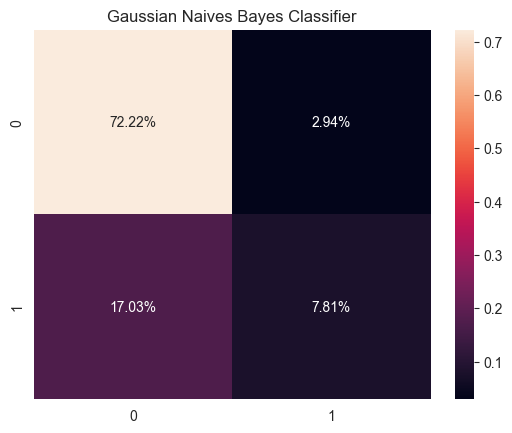

In [503]:
# confusion matrix of testing data prediction 
confusion = confusion_matrix(Y_test.values.ravel(),
                             clf_GB.predict(X_test))
sns.heatmap(confusion/confusion.sum(),
            annot=True,
           fmt= '.2%')
plt.title('Gaussian Naives Bayes Classifier')
plt.show()

In [504]:
print(f'Gaussian NB training accuracy : {round(clf_GB.score(X_train,Y_train.values.ravel())*100,2)}%')
print(f'Gaussian NB testing accuracy : {round(clf_GB.score(X_test,Y_test.values.ravel())*100,2)}%')

Gaussian NB training accuracy : 80.04%
Gaussian NB testing accuracy : 80.04%


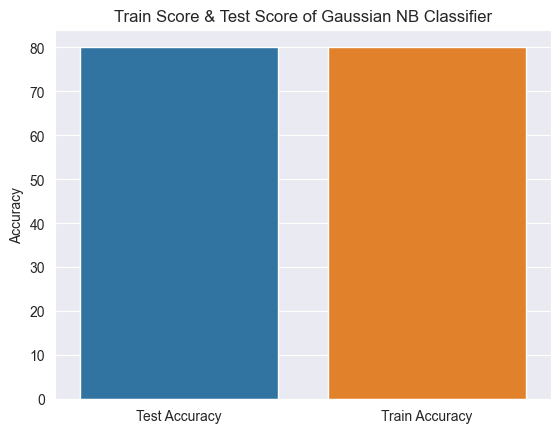

In [505]:
sns.barplot(x=['Test Accuracy','Train Accuracy'],
            y=[round(accuracy_score(Y_train,clf_GB.predict(X_train))*100,2),
              round(accuracy_score(Y_test,clf_GB.predict(X_test))*100,2)])
plt.ylabel('Accuracy')
plt.title('Train Score & Test Score of Gaussian NB Classifier')
plt.show()

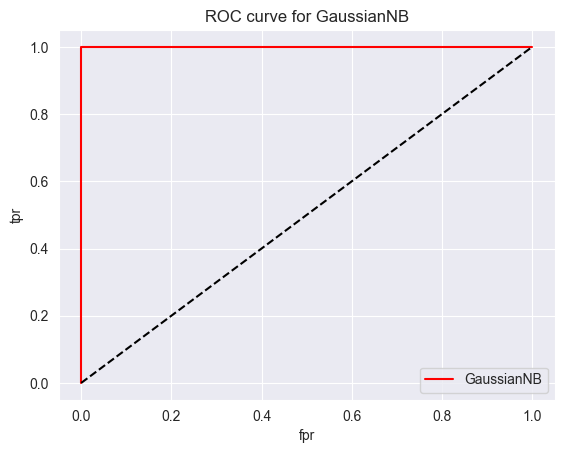

In [506]:
# conclude our classifier is perfect one 
fpr, tpr, thresh = roc_curve(clf_GB.predict(X_test).ravel(),
                             clf_GB.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,color='red',label='GaussianNB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve for GaussianNB')
plt.legend()
plt.show()

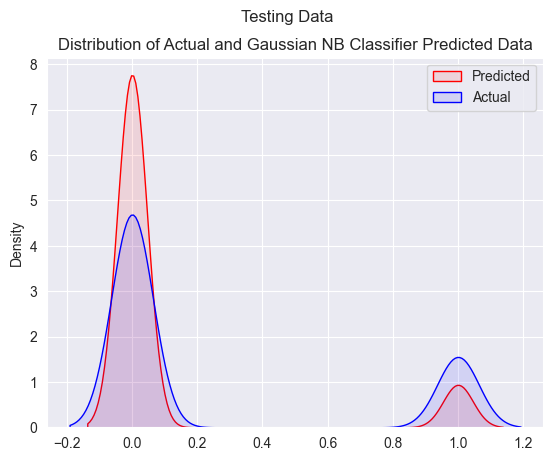

In [507]:
sns.distplot(clf_GB.predict(X_test),hist=False,color='red',
                              kde_kws={'shade':True,'alpha':0.1})
sns.distplot(Y_test,hist=False,color='blue',
             kde_kws={'shade':True,'alpha':0.1})
plt.legend(['Predicted','Actual'],loc='upper right')
plt.title('Distribution of Actual and Gaussian NB Classifier Predicted Data')
plt.suptitle('Testing Data')
plt.show()

In [508]:
# classification report for Gaussian NB classifier
print(classification_report(Y_test.values.ravel(),
                      clf_GB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.81      0.96      0.88     10620
           1       0.73      0.31      0.44      3510

    accuracy                           0.80     14130
   macro avg       0.77      0.64      0.66     14130
weighted avg       0.79      0.80      0.77     14130



## Multinomial Naive Bayes Classification Model

In [509]:
# hyperparameter 'alpha' tuning 
base_MB = MultinomialNB()
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]}
reproduce()
grid_MB = GridSearchCV(estimator=base_MB,
                       param_grid=param_grid,
                       cv=10,verbose=10,scoring='accuracy')
grid_MB.fit(X_train,Y_train.values.ravel())

Fitting 10 folds for each of 8 candidates, totalling 80 fits
[CV 1/10; 1/8] START alpha=1e-05................................................
[CV 1/10; 1/8] END .................alpha=1e-05;, score=0.767 total time=   0.0s
[CV 2/10; 1/8] START alpha=1e-05................................................
[CV 2/10; 1/8] END .................alpha=1e-05;, score=0.773 total time=   0.0s
[CV 3/10; 1/8] START alpha=1e-05................................................
[CV 3/10; 1/8] END .................alpha=1e-05;, score=0.775 total time=   0.0s
[CV 4/10; 1/8] START alpha=1e-05................................................
[CV 4/10; 1/8] END .................alpha=1e-05;, score=0.766 total time=   0.0s
[CV 5/10; 1/8] START alpha=1e-05................................................
[CV 5/10; 1/8] END .................alpha=1e-05;, score=0.781 total time=   0.0s
[CV 6/10; 1/8] START alpha=1e-05................................................
[CV 6/10; 1/8] END .................alpha=1e-05;

[CV 9/10; 6/8] END ....................alpha=10;, score=0.782 total time=   0.0s
[CV 10/10; 6/8] START alpha=10..................................................
[CV 10/10; 6/8] END ...................alpha=10;, score=0.776 total time=   0.0s
[CV 1/10; 7/8] START alpha=100..................................................
[CV 1/10; 7/8] END ...................alpha=100;, score=0.767 total time=   0.0s
[CV 2/10; 7/8] START alpha=100..................................................
[CV 2/10; 7/8] END ...................alpha=100;, score=0.773 total time=   0.0s
[CV 3/10; 7/8] START alpha=100..................................................
[CV 3/10; 7/8] END ...................alpha=100;, score=0.775 total time=   0.0s
[CV 4/10; 7/8] START alpha=100..................................................
[CV 4/10; 7/8] END ...................alpha=100;, score=0.766 total time=   0.0s
[CV 5/10; 7/8] START alpha=100..................................................
[CV 5/10; 7/8] END .........

GridSearchCV(cv=10, estimator=MultinomialNB(),
             param_grid={'alpha': [1e-05, 0.0001, 0.001, 0.1, 1, 10, 100,
                                   1000]},
             scoring='accuracy', verbose=10)

In [510]:
print(f'Multinomial Naive Bayes Classifier gives best score of {round(grid_MB.best_score_*100,4)}% with alpha value of {list(grid_MB.best_params_.values())[0]}')

Multinomial Naive Bayes Classifier gives best score of 77.339% with alpha value of 1e-05


In [511]:
# MultinomialNB with tunned parameter 
best_alpha = list(grid_MB.best_params_.values())[0]
clf_MB = MultinomialNB(alpha=best_alpha)
clf_MB.fit(X_train,Y_train.values.ravel())

MultinomialNB(alpha=1e-05)

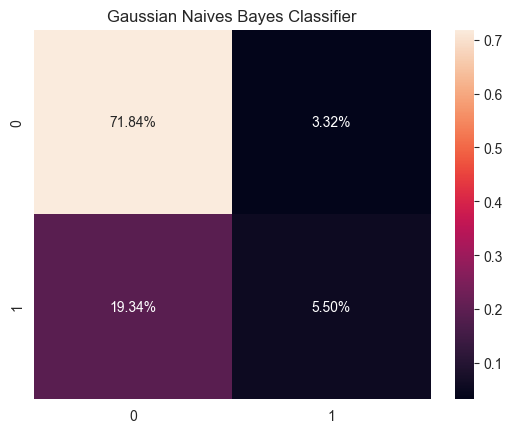

In [512]:
# confusion matrix of testing data prediction 
confusion = confusion_matrix(Y_test.values.ravel(),
                             clf_MB.predict(X_test))
sns.heatmap(confusion/confusion.sum(),
            annot=True,
           fmt= '.2%')
plt.title('Gaussian Naives Bayes Classifier')
plt.show()

In [513]:
print(f'Gaussian NB training accuracy : {round(clf_MB.score(X_train,Y_train.values.ravel())*100,2)}%')
print(f'Gaussian NB testing accuracy : {round(clf_MB.score(X_test,Y_test.values.ravel())*100,2)}%')

Gaussian NB training accuracy : 77.34%
Gaussian NB testing accuracy : 77.34%


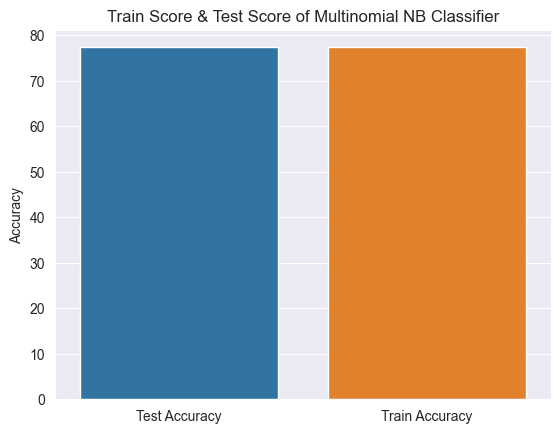

In [514]:
sns.barplot(x=['Test Accuracy','Train Accuracy'],
            y=[round(accuracy_score(Y_train,clf_MB.predict(X_train))*100,2),
              round(accuracy_score(Y_test,clf_MB.predict(X_test))*100,2)])
plt.ylabel('Accuracy')
plt.title('Train Score & Test Score of Multinomial NB Classifier')
plt.show()

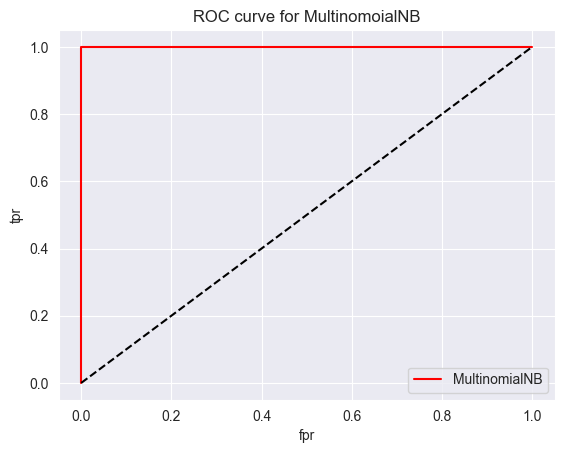

In [515]:
# conclude our classifier is perfect one 
fpr, tpr, thresh = roc_curve(clf_MB.predict(X_test).ravel(),
                             clf_MB.predict_proba(X_test)[:,1])
plt.plot(fpr,tpr,color='red',label='MultinomialNB')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.plot([0,1],[0,1],'k--')
plt.title('ROC curve for MultinomoialNB')
plt.legend()
plt.show()

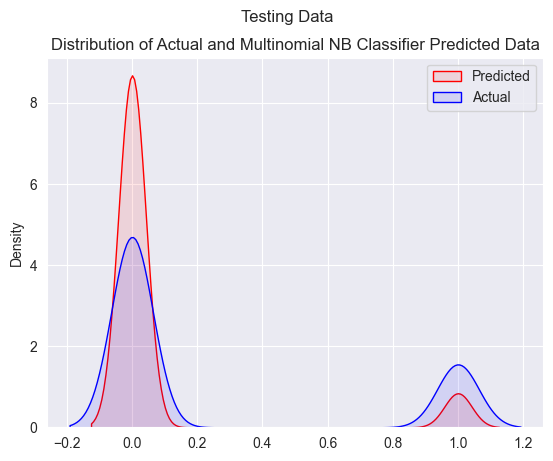

In [516]:
sns.distplot(clf_MB.predict(X_test),hist=False,color='red',
                              kde_kws={'shade':True,'alpha':0.1})
sns.distplot(Y_test,hist=False,color='blue',
             kde_kws={'shade':True,'alpha':0.1})
plt.legend(['Predicted','Actual'],loc='upper right')
plt.title('Distribution of Actual and Multinomial NB Classifier Predicted Data')
plt.suptitle('Testing Data')
plt.show()

In [517]:
# classification report for Multinomial NB classifier
print(classification_report(Y_test.values.ravel(),
                      clf_MB.predict(X_test)))

              precision    recall  f1-score   support

           0       0.79      0.96      0.86     10620
           1       0.62      0.22      0.33      3510

    accuracy                           0.77     14130
   macro avg       0.71      0.59      0.60     14130
weighted avg       0.75      0.77      0.73     14130



## GaussianNB and MultinomialNB are giving F1-score of 77% and 73% respectively therefore choosing GaussianNB as our final  classifier model.

In [518]:
# predicted salary by selected model (Gaussian NB)
pred_salary = clf_GB.predict(X_test).copy().astype('object')
for k in encDict['Salary'].keys():
    pred_salary[pred_salary == k] = encDict['Salary'][k]
final = X_test.replace(encDict)

In [519]:
final['predicted Salary'] = pred_salary

In [520]:
final.head()

,age,workclass,education,educationno,maritalstatus,occupation,relationship,race,sex,capitalgain,capitalloss,hoursperweek,native,predicted Salary
0,25,Private,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,<=50K
3,44,Private,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,34,Private,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K


## constructed Gaussian Naive Bayes Classifier to predict salary of an individual given some information about them.